# 머신러닝 모델링 (Machine Learning Modeling)

## 1. 개요
이 노트북은 전처리된 이커머스 배송 데이터(`processed_train.csv`)를 활용하여 배송 지연 여부(`Reached_on_Time`)를 예측하는 모델을 구축하고 평가합니다.
**머신러닝 모델러(ML Modeler)**의 역할에 따라 다양한 알고리즘을 적용하고 최적화하여 최고의 성능을 내는 모델을 찾는 것이 목표입니다.

주요 작업:
- 데이터 로드 및 분할 (Train/Validation/Test)
- 베이스라인 모델 학습 (Logistic Regression, Random Forest)
- 고급 모델 학습 (XGBoost, LightGBM)
- AutoGluon을 활용한 자동화된 모델링 및 앙상블
- 모델 성능 평가 및 비교 (Accuracy, F1-score, ROC-AUC)
- Feature Importance 분석

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os

# 머신러닝 라이브러리
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# AutoGluon
try:
    from autogluon.tabular import TabularPredictor
    autogluon_installed = True
except ImportError:
    print("AutoGluon is not installed. !pip install autogluon")
    autogluon_installed = False

warnings.filterwarnings('ignore')

# 한글 폰트 설정 (Windows 기준)
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

## 2. 데이터 로드 및 준비

In [5]:
# 데이터 로드
data_path = './data/processed_train.csv'
if not os.path.exists(data_path):
    # 만약 상대 경로로 찾을 수 없다면 절대 경로 시도 혹은 에러 처리
    print(f"Warning: {data_path} not found. Checking current directory.")
    if os.path.exists('processed_train.csv'):
        data_path = 'processed_train.csv'
    else:
        # 직접 생성해야 할 수도 있음
        print("Error: Processed data file not found!")

df = pd.read_csv(data_path)

print("데이터 크기:", df.shape)
display(df.head())

데이터 크기: (10999, 21)


,Product_importance,Warehouse_block_B,Warehouse_block_C,Warehouse_block_D,Warehouse_block_F,Mode_of_Shipment_Road,Mode_of_Shipment_Ship,Gender_M,Weight_Segment_Low,Weight_Segment_Medium,...,Customer_rating,Cost_of_the_Product,Prior_purchases,Discount_offered,Weight_in_gms,Discount_Rate,Cost_per_Weight,Call_Ratio,Value_Efficiency,Reached_on_Time
0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,-0.700755,-0.690722,-0.372735,1.889983,-1.468240,1.924300,1.150475,0.106910,-1.032936,1
1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,...,1.421578,0.120746,-1.029424,2.815636,-0.333893,2.189294,-0.165997,1.436478,-0.779318,1
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,...,-0.700755,-0.565881,0.283954,2.136824,-0.159002,2.072196,-0.446982,-1.555050,-0.993918,1
3,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0.006689,-0.711529,0.283954,-0.208162,-1.502484,-0.144777,1.257440,-1.056462,0.105092,1
4,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,-0.700755,-0.545074,-0.372735,2.013404,-0.703244,1.939539,-0.092202,-1.222658,0.209140,1


In [6]:
# 타겟 변수 확인
target_col = 'Reached_on_Time'
if target_col not in df.columns:
    # 전처리 과정에서 이름이 다를 수도 있으므로 확인
    if 'Reached.on.Time_Y.N' in df.columns:
        target_col = 'Reached.on.Time_Y.N'
    
print(f"Target Column: {target_col}")
print(df[target_col].value_counts(normalize=True))

Target Column: Reached_on_Time
Reached_on_Time
1    0.596691
0    0.403309
Name: proportion, dtype: float64


In [7]:
# 학습/검증/테스트 데이터 분할 (8:1:1)
X = df.drop(columns=[target_col])
y = df[target_col]

# 먼저 Train+Val / Test 분리 (9:1)
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.1, random_state=42, stratify=y)

# Train / Val 분리 (8:1 -> 8/9 : 1/9)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=1/9, random_state=42, stratify=y_temp)

print(f"Train set: {X_train.shape}")
print(f"Validation set: {X_val.shape}")
print(f"Test set: {X_test.shape}")

Train set: (8799, 20)
Validation set: (1100, 20)
Test set: (1100, 20)


## 3. 모델링 및 평가 유틸리티

In [8]:
def evaluate_model(model, X_val, y_val, model_name="Model"):
    """모델 성능 평가 및 출력 함수"""
    y_pred = model.predict(X_val)
    y_pred_proba = model.predict_proba(X_val)[:, 1] if hasattr(model, "predict_proba") else None
    
    acc = accuracy_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred)
    roc_auc = roc_auc_score(y_val, y_pred_proba) if y_pred_proba is not None else 0
    
    print(f"[{model_name} Performance]")
    print(f"Accuracy: {acc:.4f}")
    print(f"F1 Score: {f1:.4f}")
    if y_pred_proba is not None:
        print(f"ROC-AUC: {roc_auc:.4f}")
    print("-" * 30)
    
    return {"Model": model_name, "Accuracy": acc, "F1_Score": f1, "ROC_AUC": roc_auc}

## 4. 베이스라인 모델 학습
기본적인 머신러닝 모델을 통해 성능의 기준점을 잡습니다.

In [9]:
results = []

# 1. Logistic Regression
lr = LogisticRegression(random_state=42)
lr.fit(X_train, y_train)
results.append(evaluate_model(lr, X_val, y_val, "Logistic Regression"))

# 2. Random Forest
rf = RandomForestClassifier(random_state=42, n_estimators=100)
rf.fit(X_train, y_train)
results.append(evaluate_model(rf, X_val, y_val, "Random Forest"))

[Logistic Regression Performance]
Accuracy: 0.6309
F1 Score: 0.6843
ROC-AUC: 0.7161
------------------------------
[Random Forest Performance]
Accuracy: 0.6564
F1 Score: 0.6797
ROC-AUC: 0.7292
------------------------------


## 5. 고급 모델 학습 (Boosting)
XGBoost와 LightGBM을 사용하여 성능을 높여봅니다.

In [10]:
# 3. XGBoost
xgb = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
xgb.fit(X_train, y_train)
results.append(evaluate_model(xgb, X_val, y_val, "XGBoost"))

# 4. LightGBM
lgbm = LGBMClassifier(random_state=42)
lgbm.fit(X_train, y_train)
results.append(evaluate_model(lgbm, X_val, y_val, "LightGBM"))

[XGBoost Performance]
Accuracy: 0.6618
F1 Score: 0.6966
ROC-AUC: 0.7434
------------------------------
[LightGBM] [Info] Number of positive: 5251, number of negative: 3548
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000643 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1376
[LightGBM] [Info] Number of data points in the train set: 8799, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.596772 -> initscore=0.392034
[LightGBM] [Info] Start training from score 0.392034
[LightGBM Performance]
Accuracy: 0.6482
F1 Score: 0.6684
ROC-AUC: 0.7222
------------------------------


## 6. AutoGluon - 모델 자동화 및 최적화
AutoGluon을 사용하여 다양한 모델을 자동으로 학습하고 최적의 앙상블을 찾습니다.

In [11]:
if autogluon_installed:
    # AutoGluon은 데이터프레임을 통째로 입력받음
    train_data = pd.concat([X_train, y_train], axis=1)
    val_data = pd.concat([X_val, y_val], axis=1)

    predictor = TabularPredictor(label=target_col, eval_metric='accuracy').fit(
        train_data,
        presets='best_quality',  # 'medium_quality_faster_train', 'high_quality', 'best_quality' 등 선택 가능
        time_limit=600
    )
else:
    print("Skipping AutoGluon step as it's not installed.")

No path specified. Models will be saved in: "AutogluonModels\ag-20260211_055037"
Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.5.0
Python Version:     3.11.14
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.26100
CPU Count:          14
Pytorch Version:    2.9.1+cpu
CUDA Version:       CUDA is not available
Memory Avail:       17.09 GB / 31.53 GB (54.2%)
Disk Space Avail:   83.97 GB / 212.20 GB (39.6%)
Presets specified: ['best_quality']
Using hyperparameters preset: hyperparameters='zeroshot'
Setting dynamic_stacking from 'auto' to True. Reason: Enable dynamic_stacking when use_bag_holdout is disabled. (use_bag_holdout=False)
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=1
DyStack is enabled (dynamic_stacking=True). AutoGluon will try to determine whether the input data is affected by stacked overfitting and enable or disable stacking as a consequence.
	

In [12]:
if autogluon_installed:
    # AutoGluon Leaderboard
    try:
        predictor.leaderboard(val_data)
    except Exception as e:
        print(f"Error displaying leaderboard: {e}")

In [13]:
if autogluon_installed:
    # AutoGluon 성능 평가
    y_pred_ag = predictor.predict(X_val)
    # predict_proba might return DataFrame, selecting positive class
    y_pred_proba_ag = predictor.predict_proba(X_val)
    if isinstance(y_pred_proba_ag, pd.DataFrame):
        y_pred_proba_ag = y_pred_proba_ag.iloc[:, 1]

    acc_ag = accuracy_score(y_val, y_pred_ag)
    f1_ag = f1_score(y_val, y_pred_ag)
    roc_auc_ag = roc_auc_score(y_val, y_pred_proba_ag)

    print(f"[AutoGluon Best Model]")
    print(f"Accuracy: {acc_ag:.4f}")
    print(f"F1 Score: {f1_ag:.4f}")
    print(f"ROC-AUC: {roc_auc_ag:.4f}")

    results.append({"Model": "AutoGluon (Ensemble)", "Accuracy": acc_ag, "F1_Score": f1_ag, "ROC_AUC": roc_auc_ag})

[AutoGluon Best Model]
Accuracy: 0.6664
F1 Score: 0.6405
ROC-AUC: 0.7255


## 7. 결과 비교 및 분석

,Model,Accuracy,F1_Score,ROC_AUC
4,AutoGluon (Ensemble),0.666364,0.640548,0.725520
2,XGBoost,0.661818,0.696574,0.743370
1,Random Forest,0.656364,0.679661,0.729156
3,LightGBM,0.648182,0.668380,0.722187
0,Logistic Regression,0.630909,0.684292,0.716130


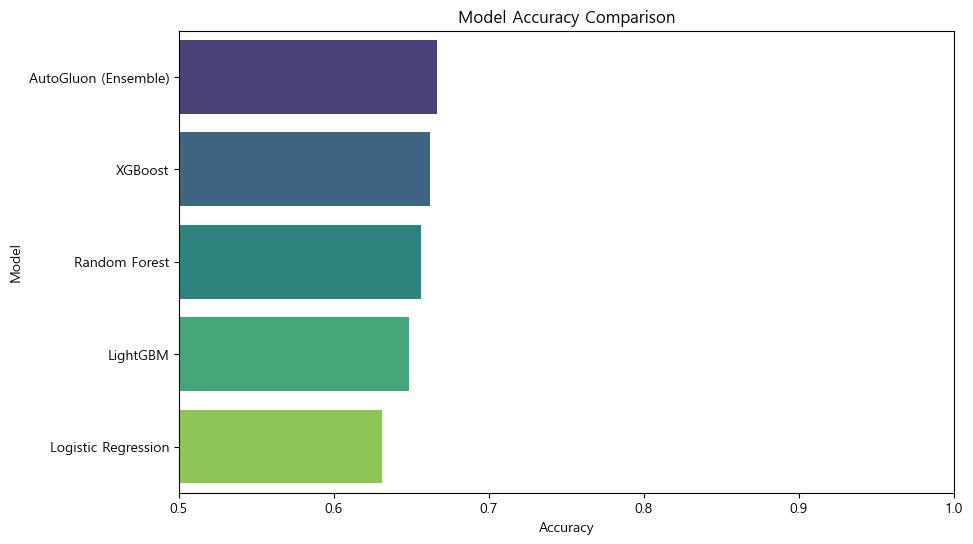

In [14]:
results_df = pd.DataFrame(results).sort_values(by="Accuracy", ascending=False)
display(results_df)

plt.figure(figsize=(10, 6))
sns.barplot(x="Accuracy", y="Model", data=results_df, palette="viridis")
plt.title("Model Accuracy Comparison")
plt.xlim(0.5, 1.0)
plt.show()

### Feature Importance (XGBoost)

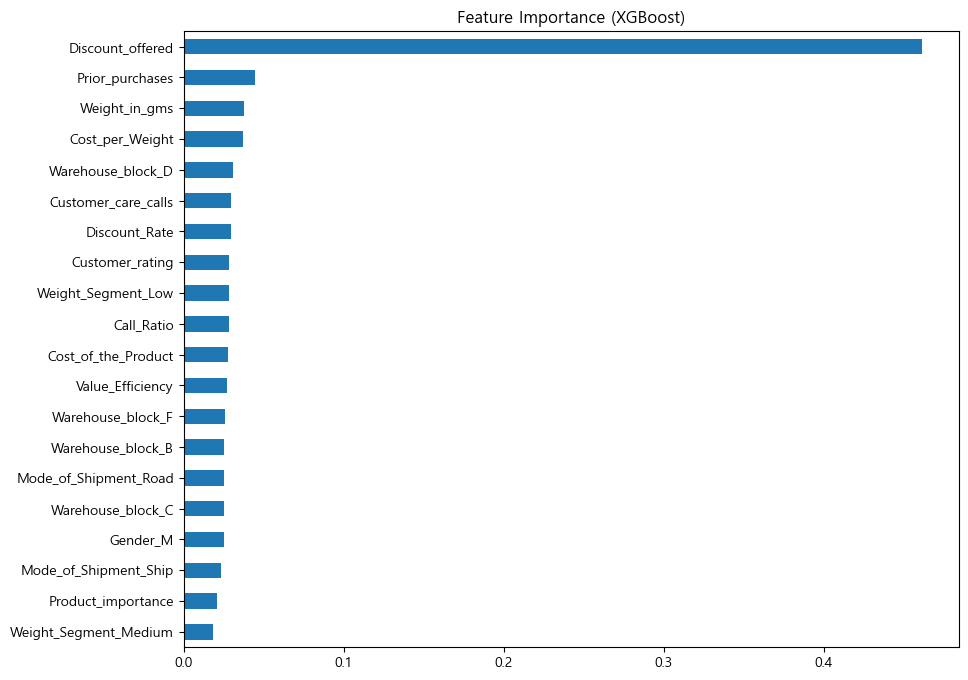

In [15]:
plt.figure(figsize=(10, 8))
importances = pd.Series(xgb.feature_importances_, index=X.columns)
importances.sort_values(ascending=True).plot(kind='barh')
plt.title("Feature Importance (XGBoost)")
plt.show()

In [16]:
# Feature Importance 추출 (Random Forest)
rf_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': rf.feature_importances_
}).sort_values(by='Importance', ascending=False)
# Feature Importance 추출 (LightGBM)
lgbm_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': lgbm.feature_importances_
}).sort_values(by='Importance', ascending=False)

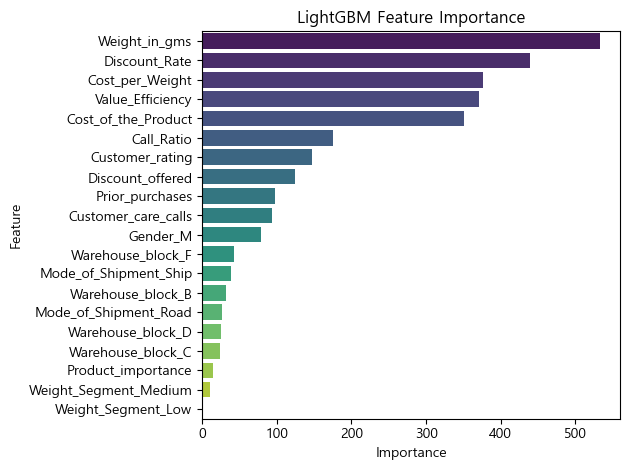

In [17]:
# LightGBM Plot
sns.barplot(x='Importance', y='Feature', data=lgbm_importance, palette='viridis')
plt.title('LightGBM Feature Importance')
plt.tight_layout()
plt.show()

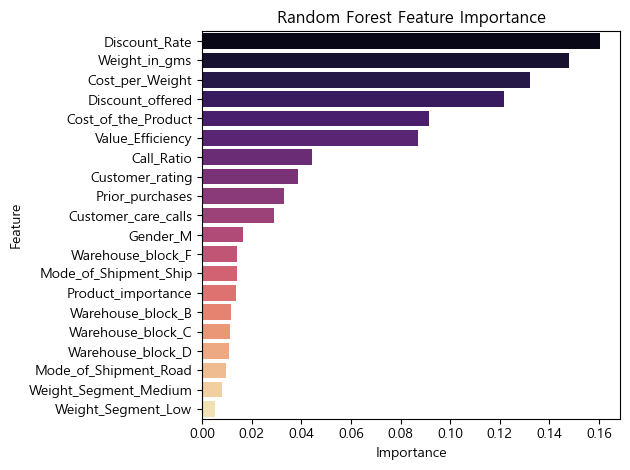

In [18]:
# Random Forest Plot
sns.barplot(x='Importance', y='Feature', data=rf_importance, palette='magma')
plt.title('Random Forest Feature Importance')
plt.tight_layout()
plt.show()

Computing feature importance via permutation shuffling for 20 features using 1100 rows with 5 shuffle sets...
	53.57s	= Expected runtime (10.71s per shuffle set)
	29.77s	= Actual runtime (Completed 5 of 5 shuffle sets)


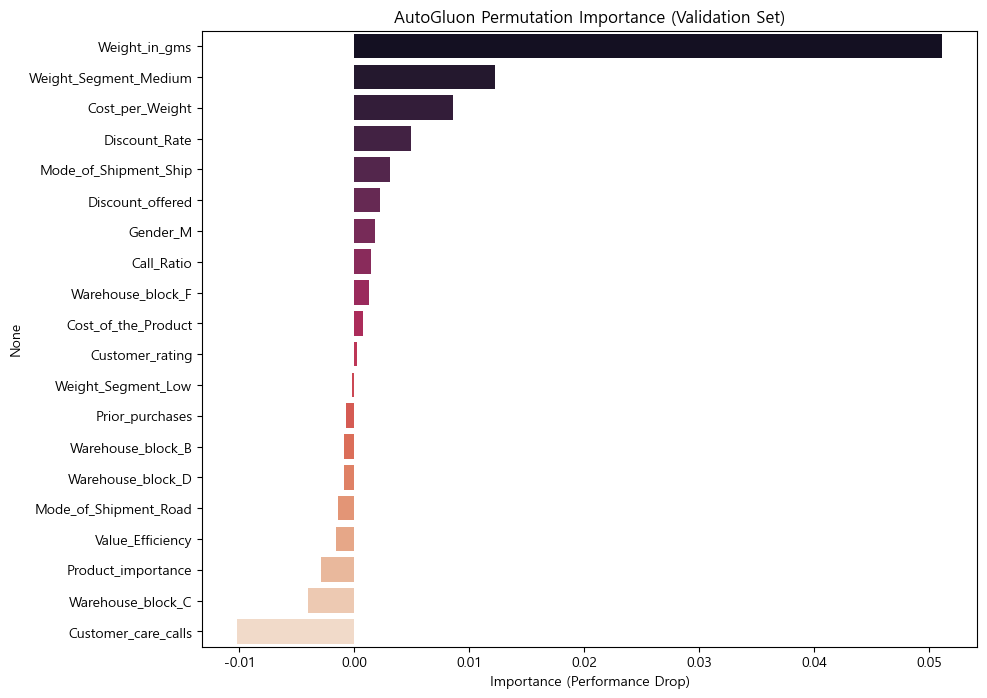

,importance,stddev,p_value,n,p99_high,p99_low
Weight_in_gms,0.051091,0.005728,0.000019,5,0.062885,0.039297
Weight_Segment_Medium,0.012182,0.010115,0.027245,5,0.033009,-0.008645
Cost_per_Weight,0.008545,0.003556,0.002897,5,0.015867,0.001224
Discount_Rate,0.004909,0.021909,0.321333,5,0.050020,-0.040202
Mode_of_Shipment_Ship,0.003091,0.003123,0.045650,5,0.009521,-0.003339
Discount_offered,0.002182,0.012491,0.358013,5,0.027902,-0.023538
Gender_M,0.001818,0.003963,0.181446,5,0.009977,-0.006341
Call_Ratio,0.001455,0.005842,0.303700,5,0.013484,-0.010575
Warehouse_block_F,0.001273,0.002619,0.169153,5,0.006665,-0.004120
Cost_of_the_Product,0.000727,0.004472,0.367267,5,0.009935,-0.008481


In [19]:
if autogluon_installed:
    # AutoGluon Feature Importance (계산 시간이 조금 소요될 수 있습니다)
    ag_importance = predictor.feature_importance(val_data)
    
    plt.figure(figsize=(10, 8))
    sns.barplot(x='importance', y=ag_importance.index, data=ag_importance, palette='rocket')
    plt.title('AutoGluon Permutation Importance (Validation Set)')
    plt.xlabel('Importance (Performance Drop)')
    plt.show()
    
    display(ag_importance)

## 8. 결론 및 제언
- AutoGluon 및 Boosting 모델들이 베이스라인 모델보다 높은 성능을 보였는지 확인합니다.
- Feature Importance를 통해 `Discount_offered`, `Weight_in_gms` 등의 변수가 중요한지 재확인합니다.
- 분석가의 인사이트(할인율, 무게 등)가 모델에서도 주요 변수로 작용하는지 검증합니다.
- 최종적으로 비즈니스에 적용하기에 적합한 모델을 PM에게 제안합니다.